# 日経平均株価 15分足

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import get_name_15min_chart, get_name_15min_chart_usd

In [3]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-01-21 09:00:00+09:00,52228.078125,52377.980469,52194.808594,52308.039062,0,0.0,0.0
2026-01-21 09:15:00+09:00,52307.828125,52467.949219,52229.511719,52422.578125,0,0.0,0.0
2026-01-21 09:30:00+09:00,52424.339844,52601.128906,52397.878906,52542.890625,0,0.0,0.0
2026-01-21 09:45:00+09:00,52545.761719,52651.601562,52528.460938,52585.171875,0,0.0,0.0
2026-01-21 10:00:00+09:00,52582.218750,52736.921875,52545.929688,52720.460938,0,0.0,0.0
2026-01-21 10:15:00+09:00,52720.941406,52796.191406,52707.531250,52732.058594,0,0.0,0.0
2026-01-21 10:30:00+09:00,52730.519531,52848.781250,52686.281250,52814.121094,0,0.0,0.0
2026-01-21 10:45:00+09:00,52822.890625,52827.570312,52766.058594,52803.261719,0,0.0,0.0
2026-01-21 11:00:00+09:00,52800.359375,52817.488281,52754.640625,52783.140625,0,0.0,0.0


In [4]:
dt_start = df.index[0]
dt_end = pd.to_datetime(
    f"{dt_start.year:04d}-{dt_start.month:02d}-{dt_start.day:02d} 15:30:00+09:00"
).tz_convert("Asia/Tokyo")
dt_start, dt_end

(Timestamp('2026-01-21 09:00:00+0900', tz='Asia/Tokyo'),
 Timestamp('2026-01-21 15:30:00+0900', tz='Asia/Tokyo'))

In [5]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 50168.11 # 12/15 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2026-01-14 00:00:00+09:00    54341.230469
2026-01-15 00:00:00+09:00    54110.500000
2026-01-16 00:00:00+09:00    53936.171875
2026-01-19 00:00:00+09:00    53583.570312
2026-01-20 00:00:00+09:00    52991.101562
2026-01-21 00:00:00+09:00    52678.371094
Name: Close, dtype: float64


Date
2026-01-20 00:00:00+09:00    52991.101562
Name: Close, dtype: float64

In [6]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-763.02


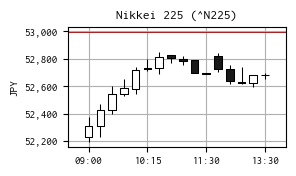

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

In [8]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

In [9]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-01-20 09:00:00+09:00,158.156998,158.281998,158.136002,158.266006,0,0.0,0.0
2026-01-20 09:15:00+09:00,158.259995,158.279007,158.097000,158.147995,0,0.0,0.0
2026-01-20 09:30:00+09:00,158.151001,158.261002,158.147995,158.238007,0,0.0,0.0
2026-01-20 09:45:00+09:00,158.235992,158.244003,157.895004,157.936005,0,0.0,0.0
2026-01-20 10:00:00+09:00,157.938004,157.964996,157.841995,157.929001,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-21 12:45:00+09:00,158.076996,158.106995,158.054993,158.087006,0,0.0,0.0
2026-01-21 13:00:00+09:00,158.087997,158.093994,157.990005,158.009003,0,0.0,0.0
2026-01-21 13:15:00+09:00,158.007004,158.044998,157.992004,158.031006,0,0.0,0.0


In [10]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2026-01-21 09:00:00+09:00,330.074873,331.022237,329.864614,330.580216
2026-01-21 09:15:00+09:00,330.670847,331.683074,330.175760,331.396254
2026-01-21 09:30:00+09:00,331.302666,332.419909,331.135443,332.051864
2026-01-21 09:45:00+09:00,332.326218,332.995603,332.216799,332.575468
2026-01-21 10:00:00+09:00,332.617811,333.596412,332.388258,333.492285
2026-01-21 10:15:00+09:00,333.788798,334.265224,333.703895,333.859184
2026-01-21 10:30:00+09:00,333.955164,334.704144,333.674992,334.484633
2026-01-21 10:45:00+09:00,334.404639,334.434264,334.044853,334.280374
2026-01-21 11:00:00+09:00,334.101245,334.209631,333.811954,333.992291


In [11]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2026-01-20 15:15:00+09:00


np.float64(158.4499969482422)

前日終値（ドル換算） 334.43422267663146


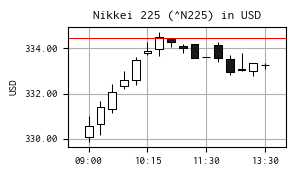

In [12]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()